In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import math

In [45]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, LSTM, Bidirectional, Dropout, Concatenate
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import keras.backend as K

In [46]:
from numpy.lib.stride_tricks import sliding_window_view

In [47]:
import tensorflow as tf

In [48]:
from IPython.display import clear_output

## Import data and transform to dataframe

In [49]:
info = pd.DataFrame({})

# Load CSV with the metadata of each sensor file

# 'two_tubes_16cm_4cm'

#for folder_distance in ['two_tubes_10cm_4cm','two_tubes_8cm_2cm','two_tubes_12cm_6cm','two_tubes_16cm_6cm','two_tubes_14cm_4cm','two_tubes_8cm_6cm','two_tubes_6cm_4cm','two_tubes_14cm_6cm','two_tubes_12cm_4cm','two_tubes_10cm_6cm']:
for folder_distance in['two_tubes_6cm_6cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info = pd.concat([info, info_aux])

In [7]:
# # Load CSV with the metadata of each sensor file

# info = pd.DataFrame({})

# for folder_distance in ['two_tubes_16cm_4cm_an']:
#     info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
#     info = pd.concat([info, info_aux])

In [40]:
!pwd ../../../

/home/martin/Desktop/Thesis/Notebooks/Distance Estimation/two_tubes


In [50]:
# This function is used mainly to join the original
# bitstream information to each file. It also creates 
# columns for visualization

def add_inputs_labels(df,row,i,injection_time,injection_amount,bit_duration):
    input_name = 'input_' + str(i)
    bitstream_name = 'bitstream_' + str(i)
    
    df[input_name] = 0
    df[bitstream_name] = row[bitstream_name][1:]

    time_add = 0
    for count, bit in enumerate(row[bitstream_name][1:].split()[0]):
        df.loc[(df.sim_time <= injection_time + time_add) & (df.sim_time >= time_add),input_name] = injection_amount*int(bit)
        time_add += bit_duration
    return df

In [53]:
# Load data from each sensor csv into a dataframe dictionary

data = {}

for index,row in info.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::10].reset_index(drop=True)
    #print(data_aux.columns)
    
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,400,1)
        distance_name = 'distance_' + str(i)
        #data_aux[distance_name] = row[distance_name]
    #print(data_aux['distance_0'][0])
    #print(data_aux['distance_1'][0])
    data.update({index: data_aux})


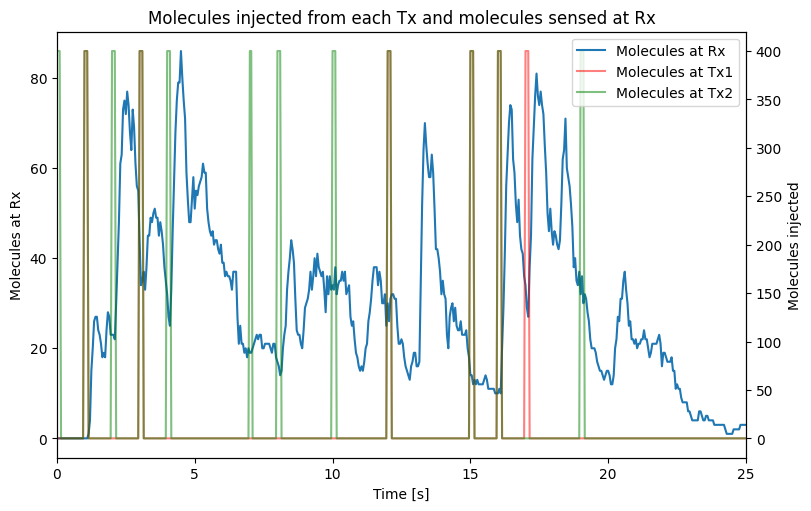

In [54]:
#Visualize each dataset
chosen_dataset = 1

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")
ax.axis(xmin=0,xmax=25)

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
fig.savefig("two_sources_10_2_mc.png", dpi=300)

In [10]:
#Separate datasets to see performance on unseen data

data_test = dict(list(data.items())[math.floor(len(data)*0.7):len(data)-1])
data = dict(list(data.items())[:math.floor(len(data)*0.7)])

## Data Augmentation and train/test split

In [16]:
# Data augmentation process, creation of input and output matrix

n_original = len(data)
n_copies = 5 # How many new datasets will be generated from one sample
index = n_original-1

for i in range(0,n_original):
    data_aux = data[i]
    for j in range(0,n_copies):
        data_aux['rel_susceptibility'] = np.random.poisson(data[i]['rel_susceptibility']) # Add poisson noise
        data.update({index: data_aux})

In [15]:
len(data[0]['bitstream_0'][0])

100

In [128]:
data[2300]

sim_time  rel_susceptibility  input_0           bitstream_0  distance_0  \
0        0.00            0.000000      400  11001010000010110100        0.04   
1        0.05            0.000000      400  11001010000010110100        0.04   
2        0.10            0.000000      400  11001010000010110100        0.04   
3        0.15            0.000000        0  11001010000010110100        0.04   
4        0.20            0.000000        0  11001010000010110100        0.04   
..        ...                 ...      ...                   ...         ...   
496     24.80          553.055252        0  11001010000010110100        0.04   
497     24.85          447.808768        0  11001010000010110100        0.04   
498     24.90          428.683279        0  11001010000010110100        0.04   
499     24.95          443.811910        0  11001010000010110100        0.04   
500     25.00          438.927540        0  11001010000010110100        0.04   

     input_1           bitstream_1  distance_1  
0        400  10110100111110001001        0.12  
1        400  10110100111110001001        0.12  
2        400  10110100111110001001        0.12  
3          0  10110100111110001001        0.12  
4          0  10110100111110001001        0.12  
..       ...                   ...         ...  
496        0  10110100111110001001        0.12  
497        0  10110100111110001001        0.12  
498        0  10110100111110001001        0.12  
499        0  10110100111110001001        0.12  
500        0  10110100111110001001        0.12  

[501 rows x 8 columns]

In [56]:
# Create the input and output matrix
    
x_all = np.zeros((len(data),data[0]['molecule_count'].size))
y_all = np.zeros((len(data),2))
y_all_bitstream = np.zeros((len(data),2,len(data[0]['bitstream_0'][0])))


for i in range(0,len(data)):
    x_all[i] = data[i]['molecule_count']
    #y_all[i] = [data[i]['distance_0'][0],data[i]['distance_1'][0]]
    y_all[i] = [0.06, 0.06]
    y_all_bitstream[i][0] = [int(i) for i in data[i]['bitstream_0'][0]]
    y_all_bitstream[i][1] = [int(i) for i in data[i]['bitstream_1'][0]]


## Data training

In [57]:
y_all_bitstream[0]

array([[1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0.]])

In [183]:
y_all.shape

(1092, 2)

In [37]:
ml_result_table = np.zeros([y_all.shape[0],4])

In [38]:
ml_result_table.shape

(99, 4)

In [137]:
from scipy.optimize import minimize

data_rate = 1
N_tx = 5500
#v_eff = 0.09 # m/s
v_eff_0 = 0.05 # m/s
v_eff_1 = 0.05 # m/s
rx_length = 0.025
tx_length = 0.01

model_chosen = 9

sequence = np.zeros([2,len(y_all_bitstream[model_chosen][0])])


t_i = np.arange(0,25,0.05)


def ob_prob(d,v_eff,rx_length,t):
    t_1 = (d-rx_length/2-tx_length/2)/(2*v_eff)
    t_2 = (d+rx_length/2+tx_length/2)/(2*v_eff)
    
    #print("Distance between source and receiver is: " + str(d[0]) + " m")
    
    if t>=t_1 and t<=t_2:
        return 1 - (d-rx_length/2-tx_length/2)/(2*v_eff*t)
    if t > t_2:
        return (d-rx_length/2+tx_length/2)/(12*2*v_eff*t)
        #return 0
    else: 
        return 0


def mean_mol_number(d,sequence,v_eff,t):
    aux = 0
    
    for i in range(0,len(sequence)):
        aux = aux + sequence[i]*ob_prob(d,v_eff,rx_length,t-i*data_rate)
        
    if aux > 0:
        return N_tx*aux
    else:
        return 0.000001
    

    

def neg_log_likelihood(d,data):
    
    log_likelihood = 0
    
    #print("Distance between source and receiver is: " + str(d[0]) + " m")
    #print("Distance between source and receiver is: " + str(d[1]) + " m")
    
    for i in range(0,len(t_i)):
        log_likelihood = log_likelihood + data[i]*math.log(mean_mol_number(d[0],sequence[0],v_eff_0,t_i[i]) + mean_mol_number(d[1],sequence[1],v_eff_1,t_i[i])) - mean_mol_number(d[0],sequence[0],v_eff_0,t_i[i]) - mean_mol_number(d[1],sequence[1],v_eff_1,t_i[i]) - math.log(math.factorial(int(data[i])))
    
    return -log_likelihood

# def negative_log_likelihood_jac(d,x_first_test):
#     x = x_first_test
    
#     residuals = x - d
#     jac = -np.sum(residuals)
    
#     return jac
# for model_chosen in range(0,y_all.shape[0]):
#     sequence[0] = y_all_bitstream[model_chosen][0]
#     sequence[1] = y_all_bitstream[model_chosen][1]
#     x_first_test = x_all[model_chosen]

#     #Initial d_tx guess
#     initial_params = [0.12,0.19]

#     # Use the L-BFGS-B optimization method to maximize the Poisson likelihood
#     result = minimize(neg_log_likelihood, initial_params, args=(x_first_test,), method='Nelder-Mead',options={'maxiter':15})

#     # Extract the optimized parameter
#     optimized_rate = result.x
    
#     #ml_result_table[model_chosen,0] = optimized_rate[0]
#     #ml_result_table[model_chosen,1] = optimized_rate[1]
#     #ml_result_table[model_chosen,2] = y_all[model_chosen][0]+0.08
#     #ml_result_table[model_chosen,3] = y_all[model_chosen][1]+0.08
    
#     #print(ml_result_table[model_chosen,:])

#     print("Optimized Distance:", optimized_rate)
#     print("Actual Distance:", y_all[model_chosen]+0.08)

In [138]:
#df_result_table = pd.DataFrame(ml_result_table)

In [139]:
#df_result_table.columns =['d_tx_1_pred', 'd_tx_2_pred', 'd_tx_1_gt', 'd_tx_2_gt']

In [140]:
#df_result_table.to_csv('ml_vs_gt_2tx.csv')

In [141]:
y_all[6]

array([0.06, 0.06])

In [142]:
from scipy.stats import poisson

In [143]:
data_rate = 1
N_tx = 1500
v_eff_0 = 0.05 # m/s
v_eff_1 = 0.05 # m/s
rx_length = 0.025

model_chosen = 7

sequence = np.zeros([2,len(y_all_bitstream[model_chosen][0])])

sequence[0] = y_all_bitstream[model_chosen][0]
sequence[1] = y_all_bitstream[model_chosen][1]
x_first_test = x_all[model_chosen]

t_i = np.arange(0,110,0.05)

d = [0.12,0.12]

n_exp_mol = [poisson.rvs(mean_mol_number(d[0],sequence[0],v_eff_0,i) + mean_mol_number(d[1],sequence[1],v_eff_1,i),1)  for i in t_i]


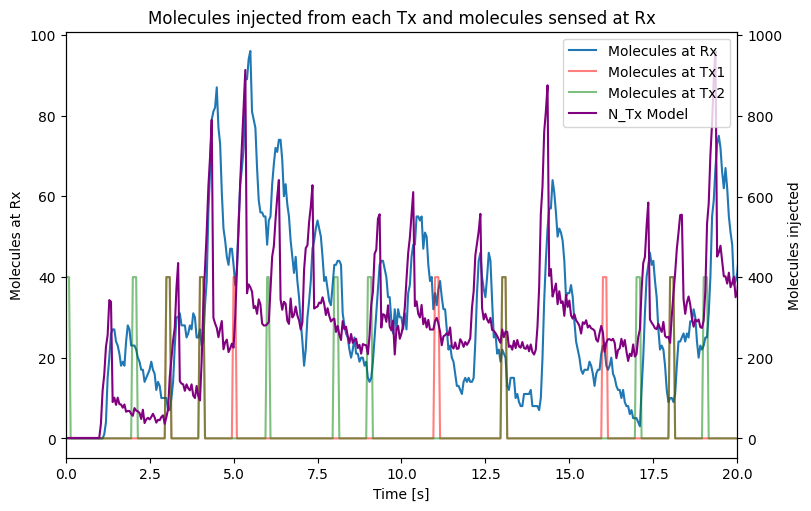

In [144]:
#Visualize each dataset
chosen_dataset = 7

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

plt.plot(t_i,n_exp_mol,color='purple', label = "N_Tx Model")

plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.xlim([0,20])
                
fig.tight_layout(pad=.3)
fig.savefig("ml_two_sources_overlay_without_tail.png", dpi=300)

In [120]:
# Initial d_tx guess
initial_params = [0.08,0.18]

# Use the L-BFGS-B optimization method to maximize the Poisson likelihood
result = minimize(neg_log_likelihood, initial_params, args=(x_first_test,), method='Nelder-Mead')

# Extract the optimized parameter
optimized_rate = result.x

print("Optimized Distance:", optimized_rate)
print("Actual Distance:", data[model_chosen]['distance'])

IndexError: index 501 is out of bounds for axis 0 with size 501

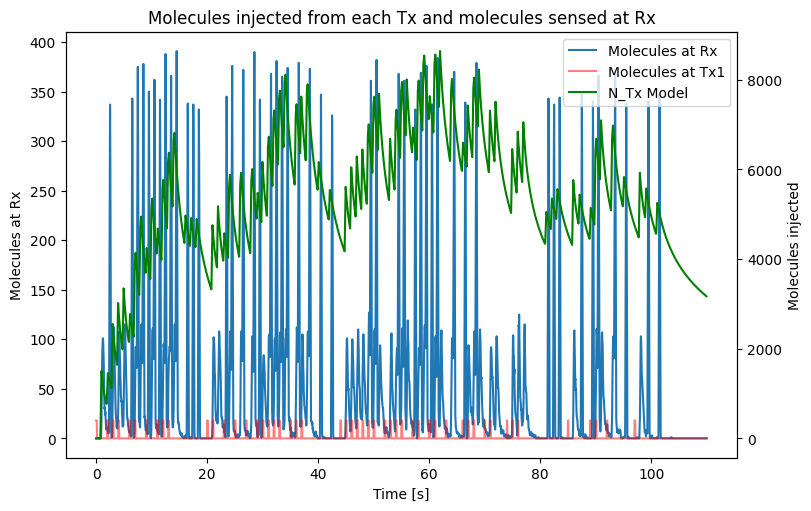

In [109]:
#Visualize each dataset
chosen_dataset = 5

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
plt.plot(t_i,n_exp_mol,color='green', label = "N_Tx Model")

plt.title("Molecules injected from each Tx and molecules sensed at Rx")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
#fig.savefig("two_sources_10_2.png", dpi=300)

In [21]:
# Neural Network Architecture

inputs = tf.keras.Input(shape=(1,n_x))

lstm_layer = Bidirectional(LSTM(128, return_sequences=True))
lstm_layer_2 = Bidirectional(LSTM(128, return_sequences=True))
#lstm_layer_3 = Bidirectional(LSTM(128, return_sequences=True))
#lstm_layer_4 = Bidirectional(LSTM(128, return_sequences=True))
x_1 = lstm_layer(inputs)
x_2 = lstm_layer_2(x_1)
#x_3 = lstm_layer_3(x_2)
#x_4 = lstm_layer_4(x_3)
hidden_dense = Dense(units=256, activation='relu')(x_2)
hidden_dense_2 = Dense(units=256, activation='relu')(hidden_dense)
#hidden_dense_3 = Dense(units=256, activation='relu')(hidden_dense_2)
#hidden_dense_4 = Dense(units=256, activation='relu')(hidden_dense_3)

output = Dense(units=n_y, activation='relu')(hidden_dense_2)

2023-04-11 03:39:53.567457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-11 03:39:53.567480: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-11 03:39:53.567498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-ubuntu): /proc/driver/nvidia/version does not exist
2023-04-11 03:39:53.567782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# Tensorflow model creation

lstm_model = Model(inputs=inputs, outputs=output, name="lstm_model")


In [23]:
# Dataset normalization

def normalize_df(df):
    df_mean = np.mean(df)
    df_std = np.std(df)
    
    if df_std == 0:
        return df
    else:
        return (df - df_mean)/df_std

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
def normalize_df(df):
    scaler = MinMaxScaler()
    #print(df.shape)
    return scaler.fit_transform(df.reshape(df.size,1))

In [26]:
# Input Normalization

x_train = np.array(list(map(normalize_df,x_train)))
x_test = np.array(list(map(normalize_df,x_test)))
x_val = np.array(list(map(normalize_df,x_val)))

In [27]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 140)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           275456    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1, 256)            65792     
                                                                 
 dense_1 (Dense)             (None, 1, 256)            65792     
                                                                 
 dense_2 (Dense)             (None, 1, 2)              5

In [28]:
# Training and validation

history = lstm_model
patience = 2
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

history.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

#x_train = normalize_df(x_train)

x_train = x_train.reshape(n_train_batches,1,n_x)
y_train = y_train.reshape(n_train_batches,1,n_y)

x_val = x_val.reshape(n_val_batches,1,n_x)
y_val = y_val.reshape(n_val_batches,1,n_y)

clear_output(wait=True)
history_data = history.fit(x=x_train,y=y_train,epochs=20, validation_data=(x_val,y_val),)
         # callbacks=[early_stopping])
    #x.append(x_eval)
    #y.append(y_eval)

#x = data[i].drop(columns=['data_index','distance'])
#y = np.array(ast.literal_eval(data[i]['bitstream'][0]))




#compile_and_fit(x_eval,y,history)





Epoch 1/20
390/390 [==============================] - 12s 17ms/step - loss: 2.1794e-04 - mean_absolute_error: 0.0090 - val_loss: 9.4864e-05 - val_mean_absolute_error: 0.0065
Epoch 2/20
390/390 [==============================] - 4s 11ms/step - loss: 8.8029e-05 - mean_absolute_error: 0.0059 - val_loss: 6.3302e-05 - val_mean_absolute_error: 0.0054
Epoch 3/20
390/390 [==============================] - 4s 11ms/step - loss: 7.1571e-05 - mean_absolute_error: 0.0052 - val_loss: 9.5427e-05 - val_mean_absolute_error: 0.0061
Epoch 4/20
390/390 [==============================] - 4s 11ms/step - loss: 5.7489e-05 - mean_absolute_error: 0.0044 - val_loss: 9.1334e-05 - val_mean_absolute_error: 0.0074
Epoch 5/20
390/390 [==============================] - 5s 12ms/step - loss: 4.1731e-05 - mean_absolute_error: 0.0037 - val_loss: 4.1753e-05 - val_mean_absolute_error: 0.0041
Epoch 6/20
390/390 [==============================] - 4s 11ms/step - loss: 3.8932e-05 - mean_absolute_error: 0.0034 - val_loss: 4.8681

In [29]:
from matplotlib.ticker import MaxNLocator

/tmp/ipykernel_5500/3499729020.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


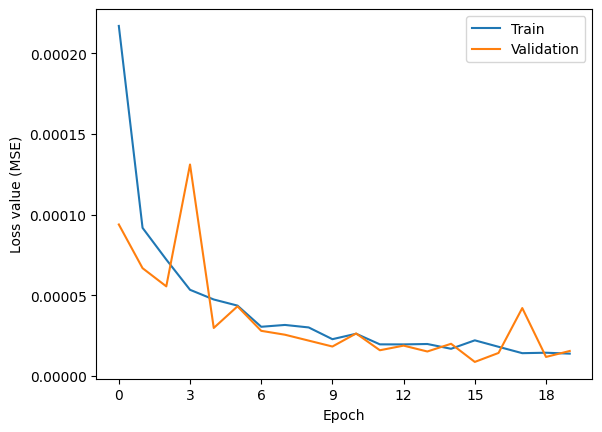

In [147]:
fig, ax = plt.subplots()

plt.plot(history_data.history['loss'])
plt.plot(history_data.history['val_loss'])


#plt.title('Loss value')
ax.set_ylabel('Loss value (MSE)')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(['Train', 'Validation'], loc='upper right')
fig.show()
fig.savefig('loss_mse_two_tubes_distance_estimation',dpi=300)

In [ ]:
# Model saving

#history.save('two_tubes_distance_model')

In [ ]:
info_test = pd.DataFrame({})

In [148]:
# Testing dataset metadata

info_test = pd.DataFrame({})
for folder_distance in ['two_tubes_14cm_5cm','two_tubes_7cm_3cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info_test = pd.concat([info_test, info_aux]) 

In [149]:
# Testing dataset loading into dictionary

data_test = {}


for index,row in info_test.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::].reset_index(drop=True)
    for i in range(0,2):
        add_inputs_labels(data_aux,row,i,0.1,5,1)
        distance_name = 'distance_' + str(i)
        data_aux[distance_name] = row[distance_name]
    data_test.update({index: data_aux})


In [232]:
# Input and output matrix for testing

test_key_list = list(data_test.keys())
first_item = test_key_list[0]

x_all_test = np.zeros((len(data_test),data_test[first_item]['rel_susceptibility'].size))
y_all_test = np.zeros((len(data_test),2))

for i in range(first_item+1,first_item + len(data_test)):
    x_all_test[i-first_item] = data_test[i]['rel_susceptibility']
    y_all_test[i-first_item] = [data_test[i]['distance_0'][0],data_test[i]['distance_1'][0]]

In [242]:
x_test_new,y_test_new = apply_sliding_window(x_all_test,y_all_test,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)

In [30]:
x_test,y_test = apply_sliding_window(x_test,y_test,bit_size=bit_size,bit_amount=bit_amount,stride=1,source_amount=source_amount,extra_padding=extra_padding,cir=True,bit_total=20)

ValueError: cannot reshape array of size 501900 into shape (53775,140)

In [31]:
# Testing

y_pred_aux = history.predict(x_test.reshape(x_test.shape[0],1,x_test.shape[1]))

113/113 [==============================] - 2s 5ms/step


In [32]:
y_pred_aux = y_pred_aux.reshape(y_pred_aux.shape[0],y_pred_aux.shape[2])

In [33]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [34]:
mae(y_test,y_pred_aux)

0.002508712083340282

In [286]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15772778374692487827
xla_global_id: -1
]


In [45]:
y_pred_aux - y_gt

array([[ 4.59152311e-04,  2.94721276e-04],
       [ 4.23348546e-04,  2.37079859e-04],
       [ 7.46361017e-04,  1.22107431e-03],
       ...,
       [-1.36238486e-04,  2.02059388e-03],
       [-1.68968886e-04,  1.84759140e-03],
       [-8.97803903e-05,  2.26992011e-03]])

In [37]:
# Dataframe for distance class performance comparison

unseen_data_test = pd.concat([pd.DataFrame(y_pred_aux,columns=['yp_d_0','yp_d_1']), pd.DataFrame(y_test,columns=['y_gt_d_0','y_gt_d_1'])],axis=1)

In [38]:
unseen_data_test['d_0_dif'] = unseen_data_test['yp_d_0'] - unseen_data_test['y_gt_d_0']

In [39]:
unseen_data_test['d_1_dif'] = unseen_data_test['yp_d_1'] - unseen_data_test['y_gt_d_1']

In [40]:
unseen_data_test['dif'] = ((unseen_data_test['yp_d_0']-unseen_data_test['y_gt_d_0'])**2+(unseen_data_test['yp_d_1']-unseen_data_test['y_gt_d_1'])**2)**(1/2)/(unseen_data_test['y_gt_d_0']**2+unseen_data_test['y_gt_d_1']**2)**(1/2)

In [41]:
unseen_data_test['class'] = unseen_data_test.apply(lambda x: str([x['y_gt_d_0'],x['y_gt_d_1']]),axis=1)


In [42]:
#unseen_data_test.to_csv('unseen_data_comparison_14_5.csv')

In [43]:
unseen_data_test['dif']

0       0.026494
1       0.054240
2       0.026896
3       0.032427
4       0.045885
          ...   
3580    0.004920
3581    0.073503
3582    0.008046
3583    0.008366
3584    0.011393
Name: dif, Length: 3585, dtype: float64

In [317]:
len(classes)

4

In [316]:
unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[1]]

yp_d_0    yp_d_1  y_gt_d_0  y_gt_d_1   d_0_dif   d_1_dif       dif  \
15    0.047455  0.071695      0.03      0.07  0.017455  0.001695  0.230277   
16    0.047455  0.071695      0.03      0.07  0.017455  0.001695  0.230277   
17    0.047455  0.071695      0.03      0.07  0.017455  0.001695  0.230277   
18    0.020923  0.077050      0.03      0.07 -0.009077  0.007050  0.150918   
19    0.022076  0.073962      0.03      0.07 -0.007924  0.003962  0.116324   
...        ...       ...       ...       ...       ...       ...       ...   
2935       NaN       NaN      0.03      0.07       NaN       NaN       NaN   
2936       NaN       NaN      0.03      0.07       NaN       NaN       NaN   
2937       NaN       NaN      0.03      0.07       NaN       NaN       NaN   
2938       NaN       NaN      0.03      0.07       NaN       NaN       NaN   
2939       NaN       NaN      0.03      0.07       NaN       NaN       NaN   

             class  
15    [0.03, 0.07]  
16    [0.03, 0.07]  
17    [0.03, 0.07]  
18    [0.03, 0.07]  
19    [0.03, 0.07]  
...            ...  
2935  [0.03, 0.07]  
2936  [0.03, 0.07]  
2937  [0.03, 0.07]  
2938  [0.03, 0.07]  
2939  [0.03, 0.07]  

[1485 rows x 8 columns]

In [44]:
classes = unseen_data_test['class'].unique()

In [47]:
classes

array(['[0.06, 0.16]', '[0.04, 0.12]', '[0.06, 0.08]', '[0.04, 0.14]',
       '[0.06, 0.14]', '[0.04, 0.16]', '[0.06, 0.12]', '[0.04, 0.1]',
       '[0.04, 0.06]', '[0.06, 0.1]', '[0.02, 0.08]'], dtype=object)

In [46]:
classes = np.delete(classes,11)

In [48]:
# Performance results

class_data = pd.DataFrame()

for i in range(0,len(classes)):
    aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[i]]
    aux_data = pd.DataFrame(index = [i],data = {"class": [classes[i]],"95_dif": [aux[aux['dif']<=0.05].count()[0]/aux.count()[0]*100]} )
    aux_data['90_dif'] = aux[aux['dif']<=0.1].count()[0]/aux.count()[0]*100
    aux_data['80_dif'] = aux[aux['dif']<=0.2].count()[0]/aux.count()[0]*100
    aux_data['50_dif'] = aux[aux['dif']<=0.5].count()[0]/aux.count()[0]*100
    aux_data['MAE'] = (abs(aux['yp_d_0']-aux['y_gt_d_0'])+abs(aux['yp_d_1']-aux['y_gt_d_1'])).mean()
    aux_data['diff'] = (aux.head(1)['y_gt_d_1'] - aux.head(1)['y_gt_d_0']).values[0]
    class_data = pd.concat([class_data, aux_data])

In [49]:
class_data

class     95_dif      90_dif      80_dif      50_dif       MAE  \
0   [0.06, 0.16]  92.982456   97.543860   99.649123  100.000000  0.006402   
1   [0.04, 0.12]  98.550725   99.420290  100.000000  100.000000  0.003545   
2   [0.06, 0.08]  68.070175   83.508772   92.982456   98.947368  0.007081   
3   [0.04, 0.14]  99.814815  100.000000  100.000000  100.000000  0.003082   
4   [0.06, 0.14]  98.765432   98.765432   98.765432  100.000000  0.003773   
5   [0.04, 0.16]  98.461538  100.000000  100.000000  100.000000  0.005054   
6   [0.06, 0.12]  93.333333   98.095238  100.000000  100.000000  0.005239   
7    [0.04, 0.1]  84.912281   90.877193   94.385965  100.000000  0.004306   
8   [0.04, 0.06]  70.175439   84.912281   90.175439   97.894737  0.006244   
9    [0.06, 0.1]  86.944444   94.722222   98.611111  100.000000  0.004118   
10  [0.02, 0.08]  98.518519   98.518519   98.888889  100.000000  0.002292   

    diff  
0   0.10  
1   0.08  
2   0.02  
3   0.10  
4   0.08  
5   0.12  
6   0.06  
7   0.06  
8   0.02  
9   0.04  
10  0.06

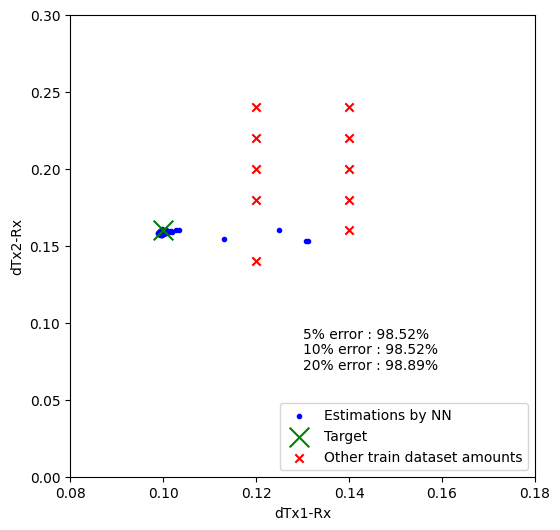

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))

color_palette = "bgrcmy"

selected_class = 10

aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[selected_class]]

plt.scatter(aux['yp_d_0']+0.08,aux['yp_d_1']+0.08,marker='.',color='b', label='Estimations by NN')

#plt.scatter(unseen_data_test['yp_d_0'],unseen_data_test['yp_d_1'])
for i in range(0,len(classes)):
    if i != selected_class:
        plt.scatter(eval(classes[i])[0]+0.08, eval(classes[i])[1]+0.08,marker='x', color='r')
    else:
        plt.scatter(eval(classes[i])[0]+0.08, eval(classes[i])[1]+0.08,marker='x', s=200, color='g', label='Target')
    
plt.scatter(-1, -1,marker='x', color='r', label='Other train dataset amounts')

#plt.text(0.13,0.1,'Amounts tested : '+str(class_data['class'][selected_class]))
plt.text(0.13,0.09,'5% error : '+str(round(class_data['95_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.08,'10% error : '+str(round(class_data['90_dif'][selected_class],2))+str('%'))
plt.text(0.13,0.07,'20% error : '+str(round(class_data['80_dif'][selected_class],2))+str('%'))


plt.xlabel("dTx1-Rx")
plt.ylabel("dTx2-Rx")

#plt.title("Distance estimation")
plt.legend(loc='lower right')

plt.xlim(0.08, 0.18)
plt.ylim(0, 0.3)

fig.savefig("two_sources_distance_estimation_seen_class_" + str(selected_class) + ".png", dpi=300)
#plt.scatter(0.05,0.14,color='green',marker='x')



(0.005, 0.2)

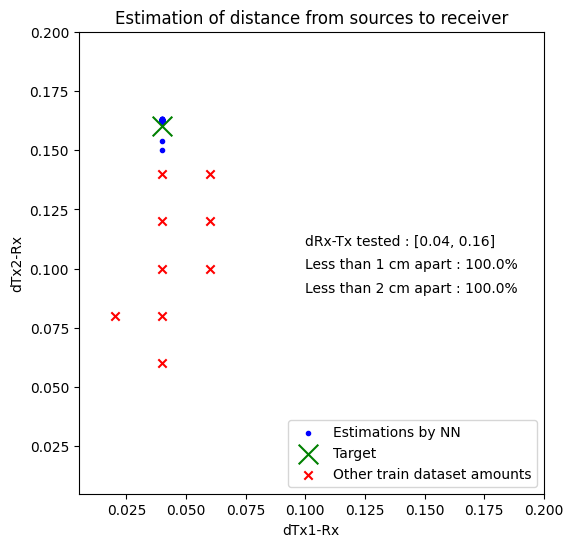

In [74]:
fig, ax = plt.subplots(figsize=(6, 6))

color_palette = "bgrcmy"

selected_class = 4

aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[selected_class]]

plt.scatter(aux['yp_d_0'],aux['yp_d_1'],marker='.',color='b', label='Estimations by NN')

#plt.scatter(unseen_data_test['yp_d_0'],unseen_data_test['yp_d_1'])
for i in range(0,len(classes)):
    if i != selected_class:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', color='r')
    else:
        plt.scatter(eval(classes[i])[0], eval(classes[i])[1],marker='x', s=200, color='g', label='Target')
    
plt.scatter(0, 0,marker='x', color='r', label='Other train dataset amounts')

plt.text(0.1,0.11,'dRx-Tx tested : '+str(class_data['class'][selected_class]))
plt.text(0.1,0.1,'Less than 1 cm apart : '+str(round(class_data['l1cm_dif'][selected_class]*100,2))+str('%'))
plt.text(0.1,0.09,'Less than 2 cm apart : '+str(round(class_data['l2cm_dif'][selected_class]*100,2))+str('%'))

plt.xlabel("dTx1-Rx")
plt.ylabel("dTx2-Rx")

plt.title("Estimation of distance from sources to receiver")
plt.legend(loc='lower right')

plt.xlim(0.005, 0.2)
plt.ylim(0.005, 0.2)


#plt.scatter(0.05,0.14,color='green',marker='x')


In [75]:
fig.savefig('scatter_plot_16_4.png', dpi=300)

In [167]:
info['class'] = info.apply(lambda x: str([x['distance_0'],x['distance_1']]),axis=1)

In [1]:
eval(classes[0])[0]

NameError: name 'classes' is not defined

[0.04, 0.16]

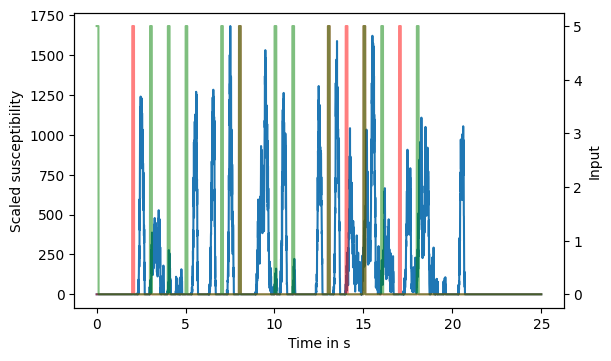

In [135]:
#Visualize each dataset
chosen_dataset = 10

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'rel_susceptibility'
y_axis_2 = 'input_0'
y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(6, 3.5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False)
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False)
sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False)
ax.set_xlabel("Time in s")
ax.set_ylabel("Scaled susceptibility")
ax2.set_ylabel("Input")

#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

fig.tight_layout(pad=.3)
fig.savefig("plot.png", dpi=300)